In [1]:
import torch
import matplotlib.pyplot as plt
from network import UNet, ShallowNet
from dataset import HMP_Dataset, HMP_Lying_Dataset, ShallowDataset
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm_notebook as tqdm
import pandas as pd

Using TensorFlow backend.


In [6]:
df = pd.read_csv('TRAINING_SET.csv')
df[df['ChildID'] == 1010101303]

,ChildID,Height_cm,Weight_kg,img,mask,joints
689,1010101303,89.7,12.2,data/HMP_FRONT_IMAGES/01010101303_F.JPG,data/HMP_FRONT_MASKS/01010101303_F.png,data/HMP_FRONT_JOINTS/01010101303_F.JPG.npy


In [2]:
np.load('logs/MODEL_14082020_074320_pretrained1/model_settings.npy')

array({'epoch': 75, 'learning_rate': 0.0001, 'height_loss': 'mae', 'batch_size': 16, 'min_neuron': 128, 'dataset': 'lying', 'is_upper': 1},
      dtype=object)

In [3]:
{'01010101314_F', '01010621314_F'}

{'01010101314_F', '01010621314_F'}

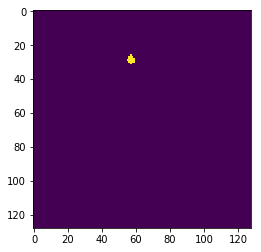

In [4]:
plt.imshow(np.load('data/HMP_FRONT_JOINTS/01010101314_F.JPG.npy') == 1)

In [39]:
np.load('JOINT_DISTANCE/01010101314_F.JPG.npy')[0, :]

array([ 0.        , 13.39073293,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  4.00042316,
        4.00693843,  0.        ,  0.        ])

In [36]:
np.save('JOINT_DISTANCE/' + '01010621314_F.JPG', 
        find_limb_length(np.load('data/HMP_FRONT_JOINTS/01010621314_F.JPG.npy')))

In [2]:
def find_limb_length(j_out):
    
    joint_dist_mat = np.zeros((18,18))
        
    neighbors = {
        0: [1,14,15], 
        1: [2,5,8,11], 
        2: [3], 
        3: [4], 
        5: [6], 
        6: [7], 
        8: [9], 
        9: [10], 
        11: [12],
        12: [13], 
        14: [16], 
        15: [17]
    }

    for point in neighbors:
        
        f_p = np.argwhere(j_out == point+1)
        
        if len(f_p) > 0:
            f_p = f_p.mean(axis=0)

            for neighbor in neighbors[point]:
                if neighbor+1 in j_out:
                    s_p = np.argwhere(j_out == neighbor+1).mean(axis=0)
                    joint_dist_mat[point, neighbor] = np.sqrt(np.sum(np.power(f_p-s_p,2)))

    return joint_dist_mat

In [27]:
np.load('JOINT_DISTANCE/01010101398_F.JPG.npy')[0,:]

array([0.        , 9.79736751, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 3.97251359,
       3.97579094, 0.        , 0.        ])

In [3]:
# Change here for lying kids !

HEIGHT_MEAN = 91.90
WEIGHT_MEAN = 12.54

# LYING

#HEIGHT_MEAN = 71.49
#WEIGHT_MEAN = 8.11

In [6]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]='1'

In [18]:
import pandas as pd

len(pd.read_csv('LYING_TEST_SET.csv'))

155

In [25]:
del model

In [24]:
person_m = mask_o.argmax(dim=1)[0].cpu().numpy()

In [28]:
np.max(np.argwhere(person_m == 1), axis=0)

array([122,  91])

In [29]:
y_h.item()

-3.4000015258789062

In [33]:
import os 
os.makedirs('JOINT_DISTANCE')

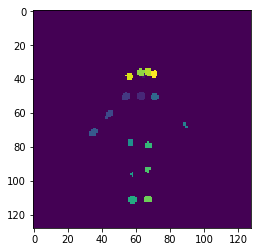

In [32]:
plt.imshow(joint_o.argmax(dim=1)[0].cpu().numpy())

In [5]:
batch_data['name']

['data/HMP_FRONT_IMAGES/01010412304_F.JPG']

In [4]:
test = DataLoader(HMP_Dataset('train'), batch_size=1, num_workers=8, shuffle=False)

model = UNet(128)
#model = ShallowNet()
model_dict = torch.load('models/MODEL_16072020_172757_pretrained1/model_ep_51.pth.tar')
model.load_state_dict(model_dict['state_dict'])
model.eval()
model = model.cuda()

res = []

l_h = []
l_w = []

heights = []
weights = []

height_errors = [[] for x in range(6)]
weight_errors = [[] for x in range(5)]

with tqdm(total=len(test), dynamic_ncols=True) as progress:
    with torch.no_grad():

        l_h = []
        l_w = []

        for idx, batch_data in enumerate(test):
            X = batch_data['img'].cuda()
            y_h = batch_data['height'].cuda()
            y_w = batch_data['weight'].cuda()

            mask_o, joint_o, height_o, weight_o, tennis_b = model(X)
            
            #height_o, weight_o = model(X)
            
            if batch_data['name'][0].split('/')[-1] == '01010101303_F.JPG':
                res.append({
                    #'img': X.permute(0,2,3,1).cpu().numpy()[0],
                    'mask': mask_o.argmax(dim=1).cpu().numpy()[0],
                    #'joint': joint_o.argmax(dim=1).cpu().numpy()[0],
                    'tennis_ball': tennis_b.cpu().numpy()[0,1],
                    'h': height_o.item(),
                    'w': weight_o.item(),
                    'y_h': y_h.item(),
                    'y_w': y_w.item()
                })
            
            h_err = abs(height_o.item() - y_h.item())
            w_err = abs(weight_o.item() - y_w.item())

            l_h.append(h_err)
            l_w.append(w_err)
            heights.append(HEIGHT_MEAN + y_h.item())
            weights.append(WEIGHT_MEAN + y_w.item())
            
            r_error_h = abs((HEIGHT_MEAN + y_h.item()) - (HEIGHT_MEAN + height_o.item()))
            r_error_w = abs((WEIGHT_MEAN + y_w.item()) - (WEIGHT_MEAN + weight_o.item()))
            
            #height_errors[int((HEIGHT_MEAN + y_h.item() - 74)//6)].append(r_error_h)
            #weight_errors[int((WEIGHT_MEAN + y_w.item() - 8)//3)].append(r_error_w)
            
            progress.update(1)

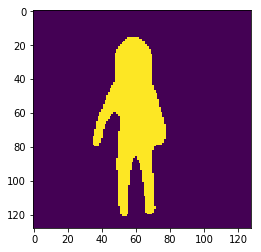

In [6]:
plt.imshow(res[0]['mask'])

In [25]:
ball_area = np.sum(res[0]['tennis_ball']>0.5)

In [26]:
ball_area

42

In [27]:
r = np.sqrt(ball_area/np.pi)

In [46]:
print("Diameter: {:.2f} px".format(2*r))
print("Child Height: {} px".format(120-16))

Diameter: 7.31 px
Child Height: 104 px


In [13]:
((4/3)*np.pi*(3.27**3)*93.61)*1.1/1000

15.081578455757253

In [8]:
18593*1.1/1000

20.452300000000005

- First Method

L: density=0.9 | R: density=1.1

    - Tennis Ball r=3.35 cm

**01010101303:** 13.26 - 16.21 kg | **Real**: 12.2 kg

    - Tennis Ball r=3.27 cm

**01010101303:** 12.33 - 15.08 kg | **Real**: 12.2 kg

***

- Second method:
    
**density:**      | 0.9 | 1 | 1.1

**01010101303:** 10.87 kg | 12.08 kg | 13.28 kg | **Real**: 12.2 kg



In [45]:
np.min(np.argwhere(res[0]['mask']==1), axis=0)

array([16, 35])

In [11]:
print("Height Error (MAE): {:.2f} cm\nWeight Error (MAE): {:.2f} kg".format(np.mean(l_h), np.mean(l_w)))

Height Error (MAE): 4.22 cm
Weight Error (MAE): 1.37 kg


# Test Set Scores

In [5]:
test = DataLoader(HMP_Dataset('val'), batch_size=1, num_workers=8, shuffle=False)

model = UNet(128)
model_dict = torch.load('models/MODEL_16072020_172757_pretrained1/model_ep_51.pth.tar')
model.load_state_dict(model_dict['state_dict'])
model.eval()
model = model.cuda()

res = []

l_h = []
l_w = []

heights = []
weights = []

height_errors = [[] for x in range(6)]
weight_errors = [[] for x in range(5)]

with tqdm(total=len(test), dynamic_ncols=True) as progress:
    with torch.no_grad():

        l_h = []
        l_w = []

        for idx, batch_data in enumerate(test):
            X = batch_data['img'].cuda()
            y_h = batch_data['height'].cuda()
            y_w = batch_data['weight'].cuda()

            mask_o, joint_o, height_o, weight_o, tennis_b = model(X)
            
            js = find_limb_length(joint_o[0].argmax(dim=0).cpu().numpy())
            np.save('JOINT_DISTANCE/' + batch_data['name'][0].split('/')[-1], js)
                        
            res.append({
                'img': X.permute(0,2,3,1).cpu().numpy()[0],
                'mask': mask_o.argmax(dim=1).cpu().numpy()[0],
                'joint': joint_o.argmax(dim=1).cpu().numpy()[0],
                'tennis_ball': tennis_b.cpu().numpy()[0,1],
                'h': height_o.item(),
                'w': weight_o.item(),
                'y_h': y_h.item(),
                'y_w': y_w.item()
            })
            
            h_err = abs(height_o.item() - y_h.item())
            w_err = abs(weight_o.item() - y_w.item())

            l_h.append(h_err)
            l_w.append(w_err)
            heights.append(HEIGHT_MEAN + y_h.item())
            weights.append(WEIGHT_MEAN + y_w.item())
            
            r_error_h = abs((HEIGHT_MEAN + y_h.item()) - (HEIGHT_MEAN + height_o.item()))
            r_error_w = abs((WEIGHT_MEAN + y_w.item()) - (WEIGHT_MEAN + weight_o.item()))
            
            height_errors[int((HEIGHT_MEAN + y_h.item() - 74)//6)].append(r_error_h)
            weight_errors[int((WEIGHT_MEAN + y_w.item() - 8)//3)].append(r_error_w)
            
            
            progress.update(1)

/data/home/can/anaconda3/envs/project/lib/python3.6/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


NameError: name 'find_limb_length' is not defined

In [6]:
b_msk = tennis_b.cpu().argmax(dim=1)[0].numpy()

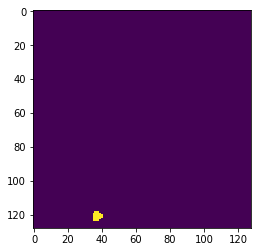

In [7]:
plt.imshow(b_msk)

In [8]:
pixels = np.argwhere(b_msk==1)

In [ ]:
a = [
    [116,  42],
    [116,  43],
    [116,  44],
    [116,  45],
    [116,  46]
]

b = [
    [122,  42],
    [122,  43],
    [122,  44],
    [122,  45]
]

In [9]:
pixels

array([[118,  36],
       [118,  37],
       [118,  38],
       [119,  35],
       [119,  36],
       [119,  37],
       [119,  38],
       [119,  39],
       [120,  35],
       [120,  36],
       [120,  37],
       [120,  38],
       [120,  39],
       [120,  40],
       [121,  35],
       [121,  36],
       [121,  37],
       [121,  38],
       [121,  39],
       [121,  40],
       [122,  35],
       [122,  36],
       [122,  37],
       [122,  38],
       [122,  39],
       [123,  35],
       [123,  36],
       [123,  37],
       [123,  38]])

In [17]:
np.max(pixels, axis=0)

array([122,  46])

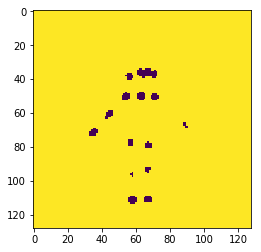

In [13]:
plt.imshow(joint_o[0].argmax(dim=0).cpu().numpy()==0)

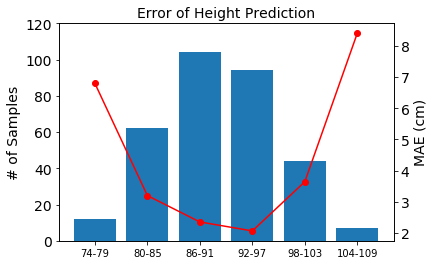

In [168]:
plt.ylim(0, 120)
plt.bar(np.arange(6), [len(x) for x in height_errors])
plt.ylabel('# of Samples', fontsize=14)
plt.title('Error of Height Prediction', fontsize=14)
plt.yticks(fontsize=14)

axes2 = plt.twinx()
axes2.plot([np.mean(x) for x in height_errors], color='r', marker='o')


_ = plt.xticks(
    np.arange(6), 
    ('74-79', '80-85', '86-91', '92-97', '98-103', '104-109'),
    rotation=45,
    fontsize=14
)

_ = plt.yticks(fontsize=14)

axes2.set_ylabel('MAE (cm)', fontsize=14)
plt.savefig('height_error.pdf', dpi=50, bbox_inches='tight')

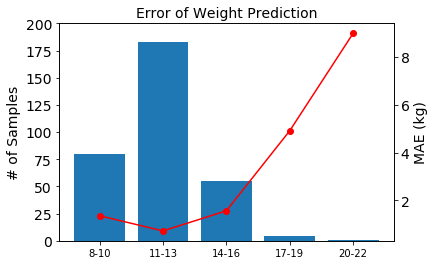

In [167]:
plt.ylim(0, 200)
plt.bar(np.arange(5), [len(x) for x in weight_errors])
plt.ylabel('# of Samples', fontsize=14)
plt.title('Error of Weight Prediction', fontsize=14)
plt.yticks(fontsize=14)

axes2 = plt.twinx()
axes2.plot([np.mean(x) for x in weight_errors], color='r', marker='o')

_ = plt.xticks(
    np.arange(5), 
    ('8-10', '11-13', '14-16', '17-19', '20-22'),
    rotation=45,
    fontsize=14
)

_ = plt.yticks(fontsize=14)

axes2.set_ylabel('MAE (kg)', fontsize=14)
plt.savefig('weight_error.pdf', dpi=50, bbox_inches='tight')

In [27]:
res = np.array(res)

In [28]:
best_height = np.argsort(l_h)[:5]
worst_height = np.argsort(l_h)[-5:]

best_weight = np.argsort(l_w)[:5]
worst_weight = np.argsort(l_w)[-5:]

In [29]:
print("Height Error (MAE): {:.2f} cm\nWeight Error (MAE): {:.2f} kg".format(np.mean(l_h), np.mean(l_w)))

Height Error (MAE): 4.69 cm
Weight Error (MAE): 1.16 kg


In [1]:
'''
m_res = worst_height

f, ax = plt.subplots(5,4, figsize=(25,25))
_ = [axi.set_axis_off() for axi in ax.ravel()]

for i in range(5):
    ax[i,0].imshow(res[m_res][i]['img'])
    ax[i,1].imshow(res[m_res][i]['mask'])
    ax[i,2].imshow(res[m_res][i]['joint'], cmap='jet')
    ax[i,3].imshow(res[m_res][i]['tennis_ball'])
    
    ax[i,0].set_title('RH: {:.2f}, PH: {:.2f} (cm)\nRW: {:.2f}, PW: {:.2f} (kg)'.format(
        res[m_res][i]['y_h'] + HEIGHT_MEAN,
        res[m_res][i]['h'] + HEIGHT_MEAN,
        res[m_res][i]['y_w'] + WEIGHT_MEAN,
        res[m_res][i]['w'] + WEIGHT_MEAN
    ), fontsize=18)
    
plt.savefig('worst_height_3.pdf', dpi=50, bbox_inches='tight')
'''

"\nm_res = worst_height\n\nf, ax = plt.subplots(5,4, figsize=(25,25))\n_ = [axi.set_axis_off() for axi in ax.ravel()]\n\nfor i in range(5):\n    ax[i,0].imshow(res[m_res][i]['img'])\n    ax[i,1].imshow(res[m_res][i]['mask'])\n    ax[i,2].imshow(res[m_res][i]['joint'], cmap='jet')\n    ax[i,3].imshow(res[m_res][i]['tennis_ball'])\n    \n    ax[i,0].set_title('RH: {:.2f}, PH: {:.2f} (cm)\nRW: {:.2f}, PW: {:.2f} (kg)'.format(\n        res[m_res][i]['y_h'] + HEIGHT_MEAN,\n        res[m_res][i]['h'] + HEIGHT_MEAN,\n        res[m_res][i]['y_w'] + WEIGHT_MEAN,\n        res[m_res][i]['w'] + WEIGHT_MEAN\n    ), fontsize=18)\n    \nplt.savefig('worst_height_3.pdf', dpi=50, bbox_inches='tight')\n"

***

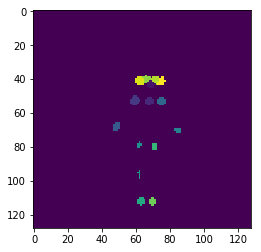

In [36]:
plt.imshow(joint_o.argmax(dim=1).cpu().numpy()[0])

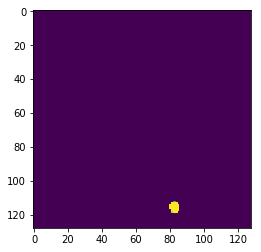

In [29]:
plt.imshow(tennis_b.cpu().numpy()[0,1])

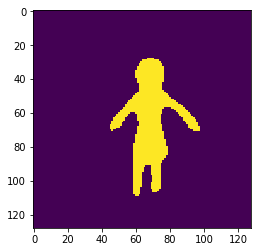

In [34]:
plt.imshow(mask_o.argmax(dim=1).cpu().numpy()[0])

In [4]:
print("Height Error (MAE): {}\nWeight Error (MAE): {}".format(np.mean(l_h), np.mean(l_w)))

Height Error (MAE): 3.6818930607392875
Weight Error (MAE): 1.3600765078648602


In [7]:
s_tl = m_scratch_dict['t_l']
s_tm = m_scratch_dict['t_m']
s_tj = m_scratch_dict['t_j']
s_th = m_scratch_dict['t_h']

s_vl = m_scratch_dict['v_l']
s_vm = m_scratch_dict['v_m']
s_vj = m_scratch_dict['v_j']
s_vh = m_scratch_dict['v_h']

In [3]:
obj = torch.load('models/SHALLOW_MODEL_26082020_091308_pretrained0/last_model_ep_50.pth.tar')

In [4]:
m_pretrain_dict = obj

p_tl = m_pretrain_dict['t_l']
p_tm = m_pretrain_dict['t_m']
p_tj = m_pretrain_dict['t_j']
p_th = m_pretrain_dict['t_h']
p_tt = m_pretrain_dict['t_t']
p_tw = m_pretrain_dict['t_w']

p_vl = m_pretrain_dict['v_l']
p_vm = m_pretrain_dict['v_m']
p_vj = m_pretrain_dict['v_j']
p_vh = m_pretrain_dict['v_h']
p_vt = m_pretrain_dict['v_t']
p_vw = m_pretrain_dict['v_w']

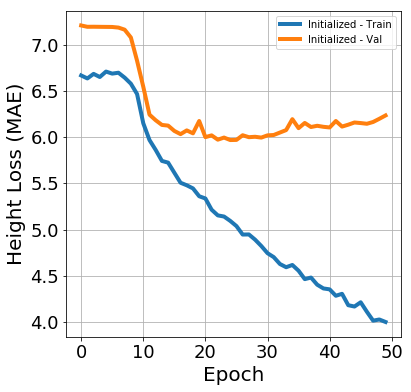

In [5]:
plt.figure(figsize=(6,6))

#plt.plot(s_th, label='Not Initialized - Train', linewidth=4, linestyle='dotted')
#plt.plot(s_vh, label='Not Initialized - Val', linewidth=4, linestyle='dotted')

plt.plot(p_tl, label='Initialized - Train', linewidth=4)
plt.plot(p_vl, label='Initialized - Val', linewidth=4)

plt.tick_params(labelsize=18)
plt.tick_params(labelsize=18)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Height Loss (MAE)', fontsize=20)
plt.legend()
plt.grid()
#plt.savefig('height_loss.png', dpi=50, bbox_inches='tight')

In [6]:
m_scratch_dict.keys()

dict_keys(['epoch', 'state_dict', 'optimizer', 't_l', 't_m', 't_j', 't_h', 'v_l', 'v_m', 'v_j', 'v_h'])

In [5]:
m_pretrain_dict

{'epoch': 30,
 'state_dict': OrderedDict([('conv_down1.conv.0.weight',
               tensor([[[[ 0.0746,  0.1291,  0.0583],
                         [ 0.2518, -0.1683, -0.1635],
                         [ 0.1930, -0.1299, -0.1809]],
               
                        [[-0.1750, -0.0651,  0.0033],
                         [-0.0962, -0.0197,  0.1078],
                         [ 0.0963, -0.0457, -0.1584]],
               
                        [[ 0.0016,  0.0555, -0.1418],
                         [-0.1084,  0.1387,  0.1678],
                         [ 0.1933, -0.0837,  0.1475]]],
               
               
                       [[[-0.0445,  0.1812,  0.0817],
                         [-0.1912, -0.0631,  0.0237],
                         [-0.0487, -0.0633, -0.1436]],
               
                        [[ 0.1274, -0.0308,  0.0964],
                         [ 0.1846,  0.2267,  0.1237],
                         [-0.1513,  0.1782, -0.0880]],
               
                 